In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 1
commitnumber = d62b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 300
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

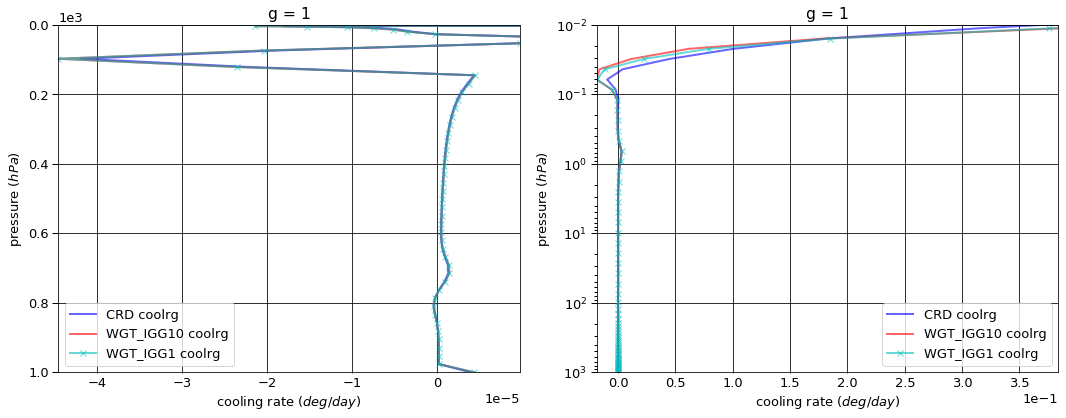

# Figure: cooling rate g-group 2

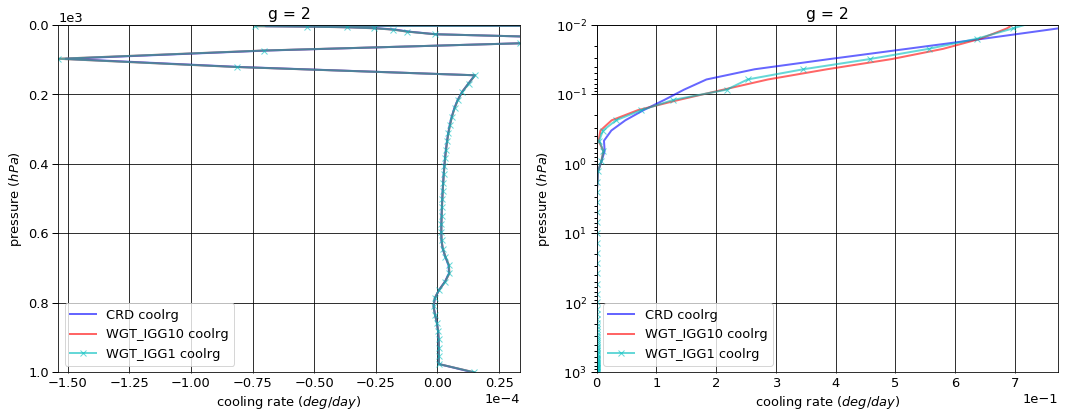

# Figure: cooling rate g-group 3

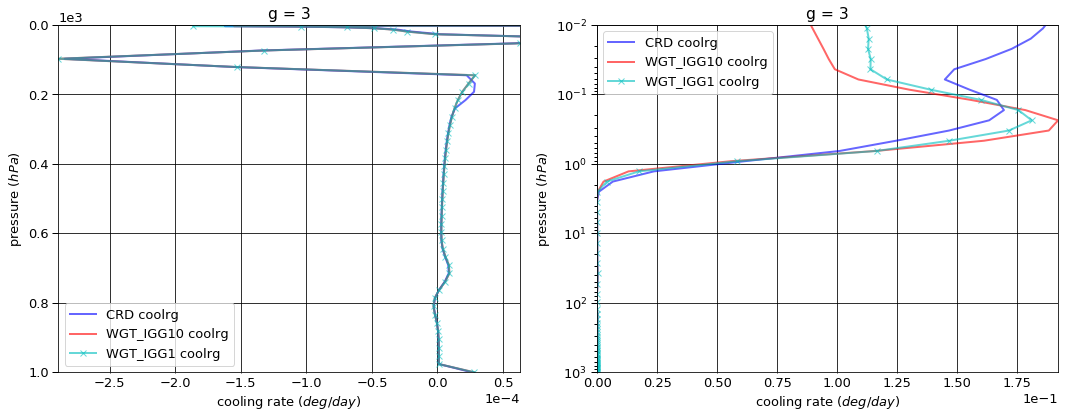

# Figure: cooling rate g-group 4

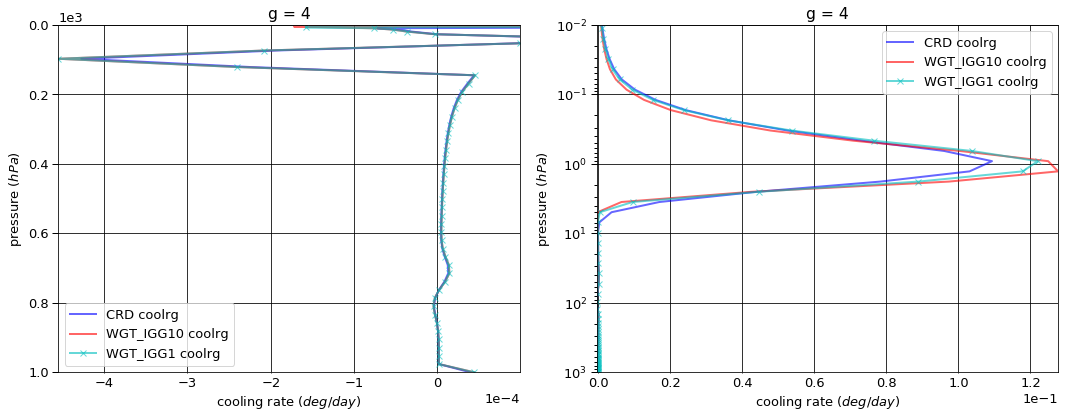

# Figure: cooling rate g-group 5

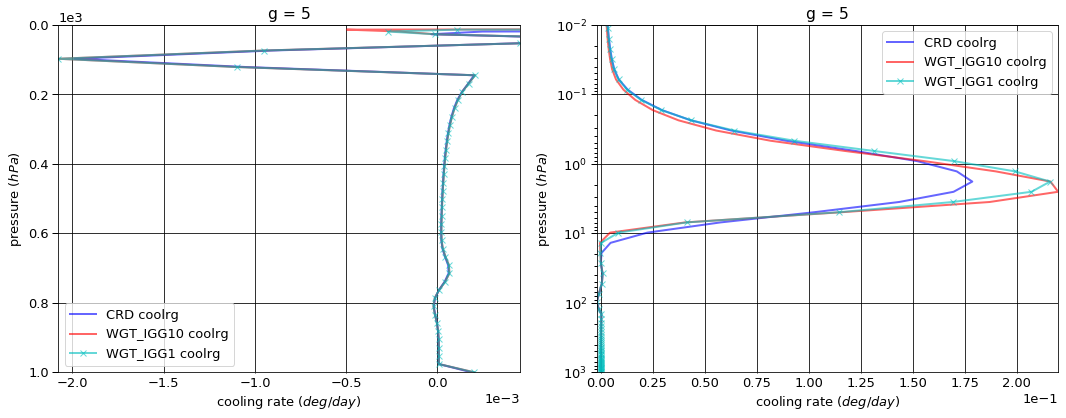

# Figure: cooling rate g-group 6

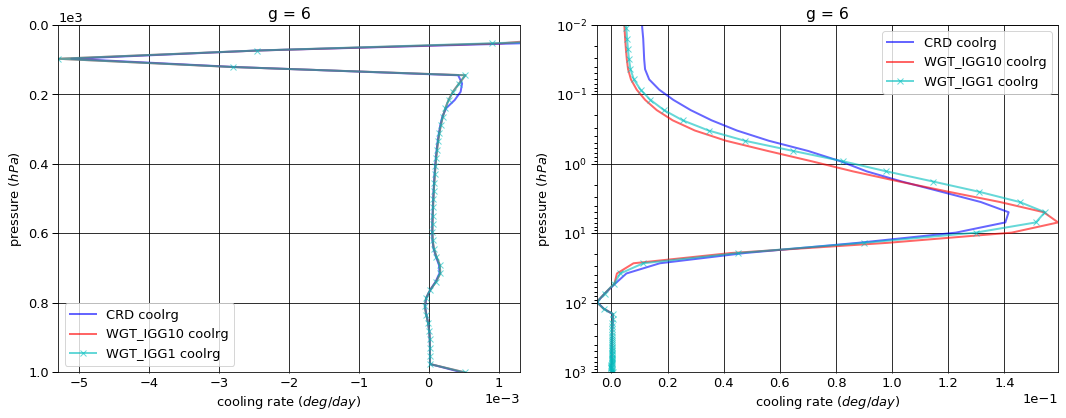

# Figure: cooling rate g-group 7

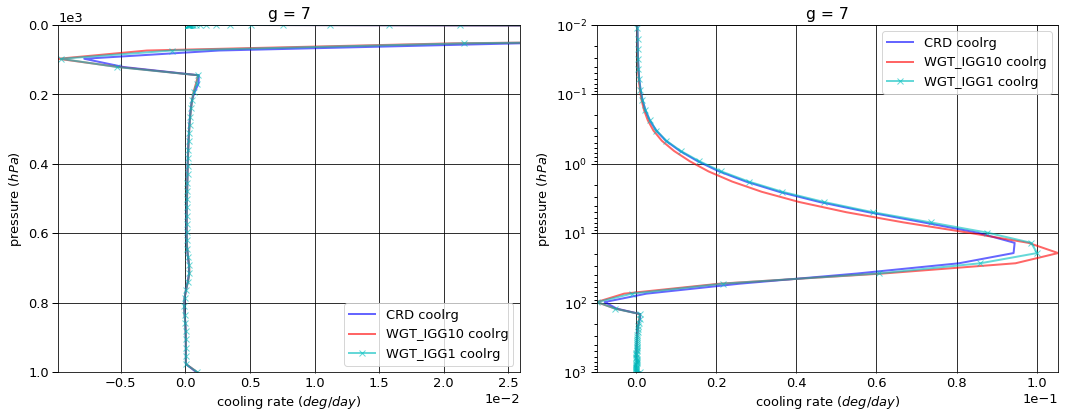

# Figure: cooling rate g-group 8

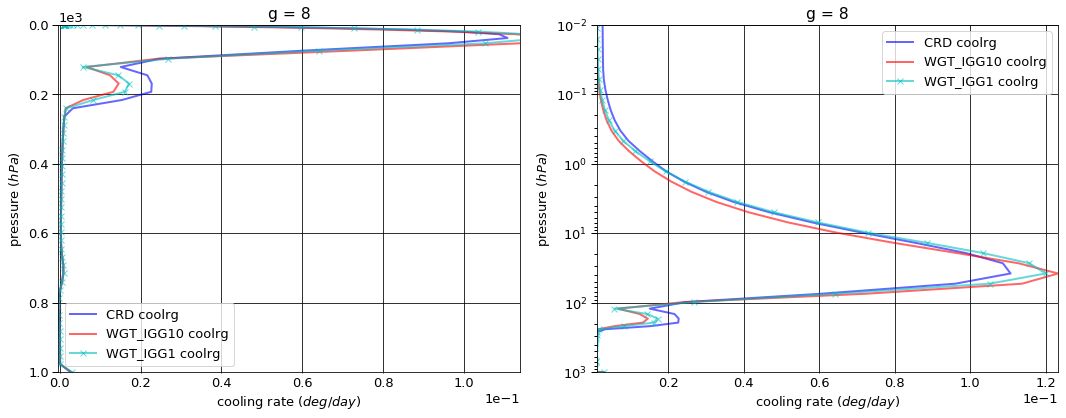

# Figure: cooling rate g-group 9

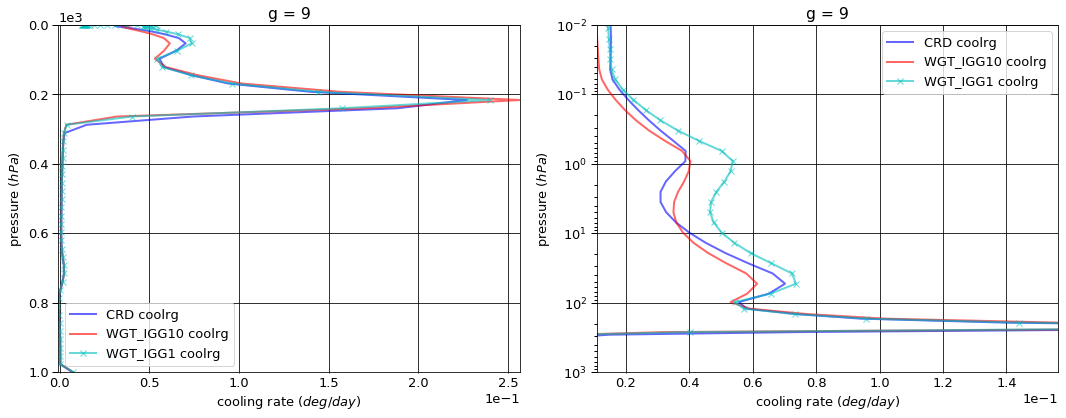

# Figure: cooling rate g-group 10

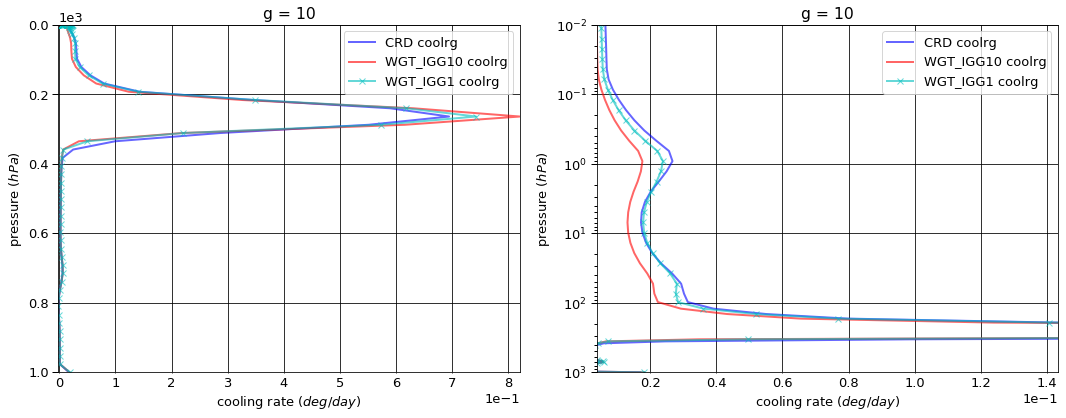

# Figure: cooling rate g-group 11

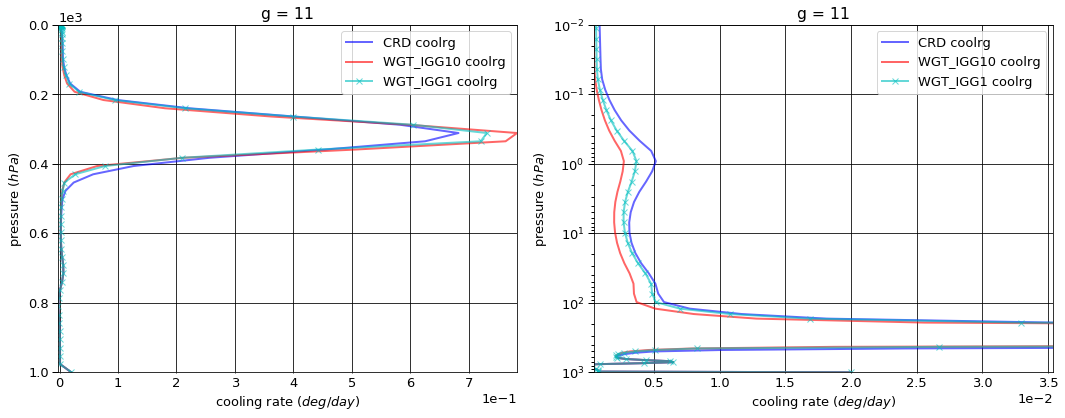

# Figure: cooling rate g-group 12

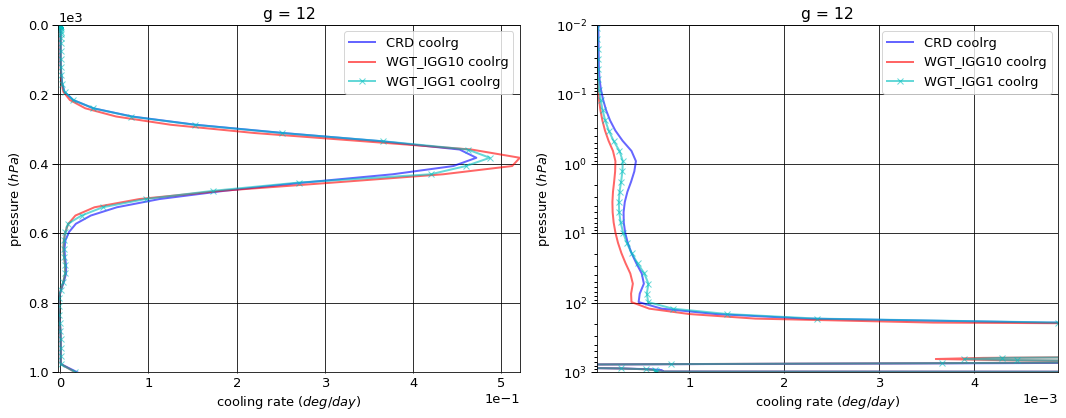

# Figure: cooling rate g-group total

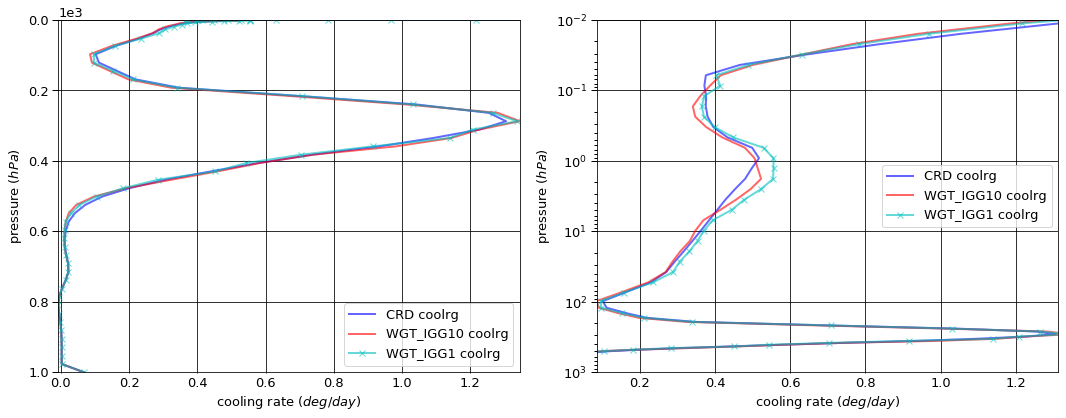

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001845   0.000000  -0.001845
   1013.0   76     -0.003282   0.003271  -0.000011
2  0.0      1      -0.006826   0.000000  -0.006826
   1013.0   76     -0.011508   0.011468  -0.000040
3  0.0      1      -0.015518   0.000000  -0.015518
   1013.0   76     -0.021517   0.021444  -0.000073
4  0.0      1      -0.026736   0.000000  -0.026736
   1013.0   76     -0.033444   0.033335  -0.000109
5  0.0      1      -0.114410   0.000000  -0.114410
   1013.0   76     -0.154051   0.153535  -0.000517
6  0.0      1      -0.262147   0.000000  -0.262147
   1013.0   76     -0.391907   0.390599  -0.001308
7  0.0      1      -0.423447   0.000000  -0.423447
   1013.0   76     -0.709530   0.707174  -0.002356
8  0.0      1      -1.246254   0.000000  -1.246254
   1013.0   76     -2.286743   2.279153  -0.007590
9  0.0      1      -3.323086   0.000000  -3.323086
   1013.0   76     -5.813139   5.793808  -0.019331
10 0.0      1      -8.784356   0.000000  -8.784356
   1013.0   76    -13.953925  13.907025  -0.046899
11 0.0      1     -10.473110   0.000000 -10.473110
   1013.0   76    -15.629408  15.574218  -0.055190
12 0.0      1      -9.680442   0.000000  -9.680442
   1013.0   76    -13.855931  13.802069  -0.053862


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001794   0.000000  -0.001794
   1013.0   76     -0.003368   0.003356  -0.000012
2  0.0      1      -0.006644   0.000000  -0.006644
   1013.0   76     -0.011614   0.011572  -0.000041
3  0.0      1      -0.015699   0.000000  -0.015699
   1013.0   76     -0.021846   0.021768  -0.000077
4  0.0      1      -0.027235   0.000000  -0.027235
   1013.0   76     -0.034356   0.034234  -0.000122
5  0.0      1      -0.116502   0.000000  -0.116502
   1013.0   76     -0.156930   0.156374  -0.000556
6  0.0      1      -0.262594   0.000000  -0.262594
   1013.0   76     -0.399842   0.398426  -0.001417
7  0.0      1      -0.420671   0.000000  -0.420671
   1013.0   76     -0.725099   0.722530  -0.002569
8  0.0      1      -1.199668   0.000000  -1.199668
   1013.0   76     -2.337541   2.329260  -0.008281
9  0.0      1      -3.221086   0.000000  -3.221086
   1013.0   76     -5.938369   5.917331  -0.021038
10 0.0      1      -8.708115   0.000000  -8.708115
   1013.0   76    -14.203822  14.153501  -0.050321
11 0.0      1     -10.476149   0.000000 -10.476149
   1013.0   76    -15.646229  15.590798  -0.055431
12 0.0      1      -9.711717   0.000000  -9.711717
   1013.0   76    -13.385368  13.337946  -0.047421


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001795   0.000000  -0.001795
   1013.0   76     -0.003368   0.003356  -0.000012
2  0.0      1      -0.006675   0.000000  -0.006675
   1013.0   76     -0.011614   0.011572  -0.000041
3  0.0      1      -0.015684   0.000000  -0.015684
   1013.0   76     -0.021846   0.021768  -0.000077
4  0.0      1      -0.027130   0.000000  -0.027130
   1013.0   76     -0.034356   0.034234  -0.000122
5  0.0      1      -0.116319   0.000000  -0.116319
   1013.0   76     -0.156930   0.156374  -0.000556
6  0.0      1      -0.262518   0.000000  -0.262518
   1013.0   76     -0.399842   0.398426  -0.001417
7  0.0      1      -0.420485   0.000000  -0.420485
   1013.0   76     -0.725099   0.722530  -0.002569
8  0.0      1      -1.207102   0.000000  -1.207102
   1013.0   76     -2.337541   2.329260  -0.008281
9  0.0      1      -3.214747   0.000000  -3.214747
   1013.0   76     -5.938369   5.917331  -0.021038
10 0.0      1      -8.653332   0.000000  -8.653332
   1013.0   76    -14.203822  14.153501  -0.050321
11 0.0      1     -10.423186   0.000000 -10.423186
   1013.0   76    -15.646229  15.590798  -0.055431
12 0.0      1      -9.668456   0.000000  -9.668456
   1013.0   76    -13.385368  13.337946  -0.047421


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000051  0.000000  0.000051
   1013.0   76    -0.000086  0.000085 -0.000001
2  0.0      1      0.000181  0.000000  0.000181
   1013.0   76    -0.000106  0.000104 -0.000001
3  0.0      1     -0.000180  0.000000 -0.000180
   1013.0   76    -0.000329  0.000325 -0.000004
4  0.0      1     -0.000498  0.000000 -0.000498
   1013.0   76    -0.000912  0.000900 -0.000013
5  0.0      1     -0.002093  0.000000 -0.002093
   1013.0   76    -0.002879  0.002839 -0.000039
6  0.0      1     -0.000446  0.000000 -0.000446
   1013.0   76    -0.007935  0.007827 -0.000108
7  0.0      1      0.002776  0.000000  0.002776
   1013.0   76    -0.015569  0.015356 -0.000213
8  0.0      1      0.046587  0.000000  0.046587
   1013.0   76    -0.050799  0.050107 -0.000691
9  0.0      1      0.102000  0.000000  0.102000
   1013.0   76    -0.125230  0.123523 -0.001707
10 0.0      1      0.076241  0.000000  0.076241
   1013.0   76    -0.249897  0.246476 -0.003422
11 0.0      1     -0.003039  0.000000 -0.003039
   1013.0   76    -0.016821  0.016580 -0.000241
12 0.0      1     -0.031275  0.000000 -0.031275
   1013.0   76     0.470563 -0.464123  0.006441


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000051  0.000000  0.000051
   1013.0   76    -0.000086  0.000085 -0.000001
2  0.0      1      0.000150  0.000000  0.000150
   1013.0   76    -0.000106  0.000104 -0.000001
3  0.0      1     -0.000166  0.000000 -0.000166
   1013.0   76    -0.000329  0.000325 -0.000004
4  0.0      1     -0.000394  0.000000 -0.000394
   1013.0   76    -0.000912  0.000900 -0.000013
5  0.0      1     -0.001909  0.000000 -0.001909
   1013.0   76    -0.002879  0.002839 -0.000039
6  0.0      1     -0.000371  0.000000 -0.000371
   1013.0   76    -0.007935  0.007827 -0.000108
7  0.0      1      0.002962  0.000000  0.002962
   1013.0   76    -0.015569  0.015356 -0.000213
8  0.0      1      0.039152  0.000000  0.039152
   1013.0   76    -0.050799  0.050107 -0.000691
9  0.0      1      0.108339  0.000000  0.108339
   1013.0   76    -0.125230  0.123523 -0.001707
10 0.0      1      0.131024  0.000000  0.131024
   1013.0   76    -0.249897  0.246476 -0.003422
11 0.0      1      0.049924  0.000000  0.049924
   1013.0   76    -0.016821  0.016580 -0.000241
12 0.0      1      0.011986  0.000000  0.011986
   1013.0   76     0.470563 -0.464123  0.006441

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      3.930002
   1001.112500 75     0.000004
2  0.000312    1      1.338296
   1001.112500 75     0.000014
3  0.000312    1      0.180653
   1001.112500 75     0.000026
4  0.000312    1      0.000100
   1001.112500 75     0.000040
5  0.000312    1      0.001797
   1001.112500 75     0.000187
6  0.000312    1      0.008751
   1001.112500 75     0.000473
7  0.000312    1      0.000223
   1001.112500 75     0.000852
8  0.000312    1      0.002365
   1001.112500 75     0.002745
9  0.000312    1      0.013468
   1001.112500 75     0.006992
10 0.000312    1      0.005527
   1001.112500 75     0.016963
11 0.000312    1      0.000726
   1001.112500 75     0.019957
12 0.000312    1      0.000030
   1001.112500 75     0.019467


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      2.381735
   1001.112500 75     0.000004
2  0.000312    1      0.719918
   1001.112500 75     0.000015
3  0.000312    1      0.072211
   1001.112500 75     0.000028
4  0.000312    1      0.000088
   1001.112500 75     0.000044
5  0.000312    1      0.001590
   1001.112500 75     0.000201
6  0.000312    1      0.003592
   1001.112500 75     0.000512
7  0.000312    1      0.000186
   1001.112500 75     0.000929
8  0.000312    1      0.000868
   1001.112500 75     0.002994
9  0.000312    1      0.009368
   1001.112500 75     0.007607
10 0.000312    1      0.003214
   1001.112500 75     0.018196
11 0.000312    1      0.000359
   1001.112500 75     0.020043
12 0.000312    1      0.000017
   1001.112500 75     0.017147


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.670449
   1001.112500 75     0.000004
2  0.000312    1      0.867834
   1001.112500 75     0.000015
3  0.000312    1      0.094469
   1001.112500 75     0.000028
4  0.000312    1      0.000108
   1001.112500 75     0.000044
5  0.000312    1      0.001840
   1001.112500 75     0.000201
6  0.000312    1      0.004075
   1001.112500 75     0.000512
7  0.000312    1      0.000214
   1001.112500 75     0.000929
8  0.000312    1      0.001001
   1001.112500 75     0.002994
9  0.000312    1      0.012543
   1001.112500 75     0.007607
10 0.000312    1      0.004467
   1001.112500 75     0.018196
11 0.000312    1      0.000500
   1001.112500 75     0.020043
12 0.000312    1      0.000023
   1001.112500 75     0.017147


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.548267e+00
   1001.112500 75     4.266288e-07
2  0.000312    1     -6.183776e-01
   1001.112500 75     5.245950e-07
3  0.000312    1     -1.084417e-01
   1001.112500 75     1.612111e-06
4  0.000312    1     -1.171229e-05
   1001.112500 75     4.505834e-06
5  0.000312    1     -2.062905e-04
   1001.112500 75     1.414721e-05
6  0.000312    1     -5.159042e-03
   1001.112500 75     3.896778e-05
7  0.000312    1     -3.700460e-05
   1001.112500 75     7.675587e-05
8  0.000312    1     -1.496970e-03
   1001.112500 75     2.490600e-04
9  0.000312    1     -4.100021e-03
   1001.112500 75     6.149343e-04
10 0.000312    1     -2.313753e-03
   1001.112500 75     1.232193e-03
11 0.000312    1     -3.672926e-04
   1001.112500 75     8.644000e-05
12 0.000312    1     -1.377561e-05
   1001.112500 75    -2.319645e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.259553e+00
   1001.112500 75     4.266288e-07
2  0.000312    1     -4.704616e-01
   1001.112500 75     5.245950e-07
3  0.000312    1     -8.618312e-02
   1001.112500 75     1.612111e-06
4  0.000312    1      8.506566e-06
   1001.112500 75     4.505834e-06
5  0.000312    1      4.310750e-05
   1001.112500 75     1.414721e-05
6  0.000312    1     -4.676390e-03
   1001.112500 75     3.896778e-05
7  0.000312    1     -8.792590e-06
   1001.112500 75     7.675587e-05
8  0.000312    1     -1.363854e-03
   1001.112500 75     2.490600e-04
9  0.000312    1     -9.244120e-04
   1001.112500 75     6.149343e-04
10 0.000312    1     -1.059865e-03
   1001.112500 75     1.232193e-03
11 0.000312    1     -2.257109e-04
   1001.112500 75     8.644000e-05
12 0.000312    1     -7.015066e-06
   1001.112500 75    -2.319645e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.358178,0.000000,-34.358178
1013.0,76,-52.864385,52.677098,-0.187287



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.167873,0.000000,-34.167873
1013.0,76,-52.864384,52.677097,-0.187287



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.017429,0.000000,-34.017429
1013.0,76,-52.864384,52.677097,-0.187287



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.903046e-01,0.000000e+00,1.903046e-01
1013.0,76,3.081000e-07,-9.378000e-07,1.656650e-07



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.407487e-01,0.000000e+00,3.407487e-01
1013.0,76,3.081000e-07,-9.378000e-07,1.656650e-07


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.481937
1001.112500,75,0.067721



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.193145
1001.112500,75,0.067721



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.657525
1001.112500,75,0.067721



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.288792e+00
1001.112500,75,-7.767120e-08



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.824412e+00
1001.112500,75,-7.767120e-08


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
